# **NUMERICAL COMPUTATIONS FOR THE EXTENDED SIAM**

<hr style="border:4px solid skyblue">

## **HOUSEKEEPING STUFF**
<hr style="border:2px solid skyblue">

In [ ]:
#### IMPORTS ####

from tqdm import tqdm
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
import numpy as np
from qutip import *


#### GLOBAL PARAMETERS ####

deltaD = 0.05
rho = 2/deltaD
nj = rho*deltaD


#### PATHS FOR SAVING FIGURES AND RAW #### 
#### DATA LIKE EIGENVALUES/VECTORS    ####

fig_save_path = "./figures/"
spectrum_path_phases = lambda D0,num,J0,J1,r0,r1,VbJ,UbyUb: "./esiam-phases-data/P-{:.5f},{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}.npy".format(D0,num,J0,J1,r0,r1,VbJ,UbyUb)
spectrum_path_E = lambda num_sites,t,U,V,J,Ub: "./esiam-spectrum/E-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites, t, U, V, J, Ub)
spectrum_path_X = lambda num_sites,t,U,V,J,Ub: "./esiam-spectrum/X-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites, t, U, V, J, Ub)
spectrum_path_E_kspace = lambda num_sites,E,U,V,J,Ub: "./esiam-spectrum/k-E-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites,E,U,V,J,Ub)
spectrum_path_X_kspace = lambda num_sites,E,U,V,J,Ub: "./esiam-spectrum/k-X-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f}".format(num_sites,E,U,V,J,Ub)
spectrum_path_SW1 = lambda num_sites,E,U,V,J,Ub,ops: "./esiam-spectrum/sw1-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.1f},{:.1f}".format(num_sites,E,U,V,J,Ub,ops[0],ops[1])
spectrum_path_SW2 = lambda num_sites,E,U,V,J,Ub,ops: "./esiam-spectrum/sw2-{:.0f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.1f},{:.1f}".format(num_sites,E,U,V,J,Ub,ops[0],ops[1])


#### STYLE MODIFICATIONS FOR PLOTTING FIGURES ####

plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 10,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "gray",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", fc="0.9")

## **DEFINITIONS OF ALL HELPER FUNCTIONS**
<hr style="border:2px solid skyblue">

## **Modules for tracking RG flow**

In [ ]:
#### RETURNS THE DENOMINATORS THAT APPEAR IN RG EQUATIONS ####

def den(w, D, U, J, K, Ub=0):
    d0 = w - D/2 + Ub/4 - U/2 + K/4
    d1 = w - D/2 + Ub/4 + U/2 + J/4
    d2 = w - D/2 + Ub/4 + J/4
    d3 = w - D/2 + Ub/4 + K/4
    return np.array([d0, d1, d2, d3])



#### RETURNS THE MODIFIED SET OF COUPLINGS AT A GIVEN RG STEP ####

def rg_flow(w, D, U, V, J, Ub=0):
    theta = lambda x: 1 if x < 0 else 0
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K, Ub=Ub)
    deltaU = 4*V**2*nj*(theta(d1)/d1 - theta(d0)/d0) - nj*J**2 * theta(d2)/(2*d2)
    deltaV = -nj*(V/8)*((3*J + 4*Ub)*(theta(d1)/d1 + theta(d2)/d2) + 4*Ub*(theta(d0)/d0 + theta(d3)/d3))
    deltaJ = -nj*(J**2 + 4*J*Ub) * theta(d2)/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J



#### SAME AS THE PREVIOUS FUNCTION rg_flow(), ####
#### BUT FOR THE J-Ub MODEL ####

def rg_J_Ub(w,D,J,Ub):
    d2 = w - D/2 + Ub/4 + J/4
    deltaJ = -nj*(J**2 + 4*J*Ub) * 1/d2 if d2 < 0 else 0
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ
    return J



#### TAKES BARE PARAMETER VALUES AND RETURNS THE COMPLETE RG FLOW ####

def complete_RG(w, D0, U0, V0, J0, Ub=0):
    signs = np.sign(den(w, D0, U0, J0, 0, Ub=Ub))
    E, U, V, J = [[g0] for g0 in (D0, U0, V0, J0)]
    for D in np.arange(D0, 0, -deltaD):
        w = -D/2
        U_j, V_j, J_j = rg_flow(w, D, U[-1], V[-1], J[-1], Ub=Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0, Ub=Ub)
        if True not in np.equal(np.sign((d0, d1, d2, d3)), signs):
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)



#### SAME AS THE PREVIOUS FUNCTION complete_RG(), ####
#### BUT FOR THE J-Ub MODEL ####

def complete_RG_J_Ub(w, D0, J0, Ub):
    d2 = w - D0/2 + Ub/4 + J0/4
    assert d2 <= 0
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        w = -D/2
        J_j = rg_J_Ub(w, D, J[-1], Ub)
        J.append(J_j)
        E.append(D - deltaD)
        d2 = w - E[-1]/2 + Ub/4 + J[-1]/4
        if d2 >= 0:
            break
    return np.array(E), np.array(J)

## **Hamiltonian designing and diagonalisation**

In [ ]:
####     TAKES A QUTIP STATE AS INPUT AND RETURNS     ####
####     THE NUMBER OF FOCK STATES AND NUMBER OF      ####
####     LATTICE SITES PRESENT WITHIN THE STATE       ####

def get_state_dim(X):
    total_dim = int(np.log2(X.shape[0]))
    total_num_sites = int(total_dim/2) # total number of sites
    assert total_num_sites == total_dim/2
    return total_dim, total_num_sites



####     (REAL SPACE) CONSTRUCTS A QUTIP HAMILTONIAN       ####
####     FOR THE ESIAM MODEL, GIVEN A SET OF PARAMETERS    ####


def get_ham_rspace(t, lattice_dim, U, V, J, Ubath=0, mu=0):
    imp_length = 1
    total_dim = 2*(imp_length + lattice_dim)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    Sz_bath = 0.5 * (c_all[2].dag()*c_all[2] - c_all[3].dag()*c_all[3])
    Sp_bath = c_all[2].dag()*c_all[3]
    Sm_bath = Sp_bath.dag()
    
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = - 0.5 * Ubath * (2*Sz_bath)**2 
    H_V = V * (c_all[0].dag() * c_all[2] + c_all[1].dag() * c_all[3])
    H_J = J * (Sz_imp * Sz_bath + 0.5 * Sp_imp * Sm_bath + 0.5 * Sm_imp * Sp_bath)
    H_t = sum([-t * c_all[i].dag() * c_all[i+2] for i in range(2*imp_length, total_dim-2)])
    H_mu = -mu * sum([c_all[i].dag()*c_all[i] for i in range(total_dim)])

    return H_U + H_J + H_V + H_V.dag() + H_t + (H_t.dag() if H_t != 0 else 0) + H_Ubath + H_mu



####     (MOM. SPACE) CONSTRUCTS A QUTIP HAMILTONIAN       ####
####     FOR THE ESIAM MODEL, GIVEN A SET OF PARAMETERS    ####


def get_ham_kspace(Ek_0, ed, U, V, J, Ubath=0, ignore=0): 
    assert ed == -U/2
    dim = len(Ek_0)
    total_dim = 2 * (dim + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    c0_up = sum([c_all[i] for i in range(2, total_dim-1-ignore, 2)])
    c0_dn = sum([c_all[i+1] for i in range(2, total_dim-1-ignore, 2)])
    S0_z = 0.5 * (c0_up.dag()*c0_up - c0_dn.dag()*c0_dn)
    S0_plus = c0_up.dag() * c0_dn
    S0_minus = S0_plus.dag()
    H_J = J * (Sz_imp * S0_z + 0.5 * (Sp_imp * S0_minus + Sm_imp * S0_plus))
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = - 0.5 * Ubath * (2*S0_z)**2 
    H_K = sum([Ek_0[i-1]*(c_all[2*i].dag()*c_all[2*i] + c_all[2*i+1].dag()*c_all[2*i+1]) for i in range(1, dim+1)])
    H_V = V * (c_all[0].dag() * c0_up + c_all[1].dag() * c0_dn)

    return H_U + H_Ubath + H_K + H_V + H_V.dag() + H_J



####    GIVEN SET OF PARAMS, RETURNS THE EIGENVALUES     ####
####    AND EIGENVECTORS OF A MODEL HAMILTONIAN, FOR     ####
####    SPECTRAL FUNCTION CALCULATIONS                   ####

def get_spectrum_kspace(num_sites,U,V,J,Ub,omega):

    try:
        E = qload(spectrum_path_E_kspace(num_sites,omega,U,V,J,Ub))
        X = qload(spectrum_path_X_kspace(num_sites,omega,U,V,J,Ub))
    except:
        num_pos = int(num_sites/2)
        num_neg = num_sites - num_pos
        Ek = np.array([omega]*num_pos + [-omega]*num_neg)*4
        ed = -U/2
        H = get_ham_kspace(Ek, ed, U, V, J, Ubath=Ub)
        E, X = H.eigenstates()
        qsave(E, spectrum_path_E_kspace(num_sites,omega,U,V,J,Ub))
        qsave(X, spectrum_path_X_kspace(num_sites,omega,U,V,J,Ub))
        
    E = np.round(E, 5)
    return E,X,len(X[E == min(E)])

## **Computation of various quantifiers (overlaps,correlation functions, entanglement, etc) in states**

In [ ]:
####     GIVEN A STATE/SET OF STATES, COMPUTES            ####
####     THE AVERAGE QFI IN THE STATE, CORRESPONDING      ####
####     TO SOME PREDEFINED OPERATORS                     ####

def get_QFI(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
        
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_all = [0.5 * (c_all[2*i].dag()*c_all[2*i] - c_all[2*i + 1].dag()*c_all[2*i + 1]) for i in range(total_num_sites)]
    Cz_all = [0.5 * (c_all[2*i].dag()*c_all[2*i] + c_all[2*i + 1].dag()*c_all[2*i + 1] - 1) for i in range(total_num_sites)]
    Sp_all = [c_all[2*i].dag() * c_all[2*i + 1] for i in range(total_num_sites)]
    Cp_all = [c_all[2*i].dag() * c_all[2*i + 1].dag() for i in range(total_num_sites)]

    SpSm = Sp_all[0] * Sp_all[1].dag() + Sp_all[1] * Sp_all[0].dag()
    Sdz = Sz_all[0]
    CpCm_01 = Cp_all[1] * Cp_all[2].dag() + Cp_all[2] * Cp_all[1].dag()
    
    QFI_labels = ("spin-flip", "charge", "spin-d")
    QFI_dict = {}
    for label,op in zip(QFI_labels, (SpSm, CpCm_01, Sdz)):
        assert op == op.dag()
        QFI_dict[label] = sum([4*np.real(np.array(X.dag() * op**2 * X)[0][0]) 
                               - 4*np.real(np.array(X.dag() * op * X)[0][0])**2
                               for X in Xgs])/len(Xgs)
    return QFI_dict



####     GIVEN A STATE/SET OF STATES AND A PAIR OF POSITIONS,    ####
####     COMPUTES THE AVERAGE MUTUAL INFORMATION BETWEEN         ####
####     SITES AT THE PROVIDED POSITIONS                         ####

def get_MI(Xgs, i, j):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    
    mut_info = 0
    for X in Xgs:
        rho = X * X.dag()
        rho_part = rho.ptrace(i+j)
        mut_info += entropy_mutual(rho_part, list(range(len(i))), list(range(len(i), len(i)+len(j))))/len(Xgs)
    return mut_info


####     GIVEN A STATE/SET OF STATES AND A POSITIONS,      ####
####     COMPUTES THE AVERAGE ENTANGL. ENTROPY             ####
####     AT THE PROVIDED LATTICE SITE                      ####

def get_EE(Xgs, i):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    ent_entr = 0
    for X in Xgs:
        rho = X * X.dag()
        rho_part = rho.ptrace((2*i, 2*i+1))
        ent_entr += entropy_vn(rho_part) / len(Xgs)
    return ent_entr



#### COMPUTES THE CORRELATION c^dag_i c_j c^dag_k c_l,    ####
#### GIVEN A STATE AND A SET OF INDICES i,j,k,l           ####

def get_2particle_corr(Xgs, guys):
    i,j,k,l = guys  
    if isinstance(Xgs, list):
        total_dim, _ = get_state_dim(Xgs[0])
        c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
        two_p_corr = sum([(X.dag() * c_all[i].dag() * c_all[j] * c_all[k].dag() * c_all[l] * X)[0][0][0] for X in Xgs]) / len(Xgs)
    else:
        total_dim, _ = get_state_dim(Xgs)
        c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
        two_p_corr = (Xgs.dag() * c_all[i].dag() * c_all[j] * c_all[k].dag() * c_all[l] * Xgs)[0][0][0]
    return two_p_corr



#### COMPUTES THE SPIN-FLIP CORRELATION IN A GIVEN    ####
#### STATE BETWEEN THE PROVIDED PAIR OF INDICES       ####

def get_spin_flip_corr(Xgs, pair):
    (i, j) = pair    
    guys_plus_minus = (2*i, 2*i+1, 2*j+1, 2*j)
    guys_minus_plus = (2*i+1, 2*i, 2*j, 2*j+1)

    return 0.5 * (get_2particle_corr(Xgs, guys_plus_minus) + get_2particle_corr(Xgs, guys_minus_plus))



#### COMPUTES THE DENSITY-DENSITY CORRELATION       ####
#### IN THE UP-UP OR DOWN-DOWN STATE, IN THE        ####
#### PROVIDED PAIR OF INDICES                       ####

def get_density_ferro_corr(Xgs, pair, spin):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    guys = (2*i, 2*i, 2*j, 2*j) if spin == 1 else (2*i+1, 2*i+1, 2*j+1, 2*j+1)
    return get_2particle_corr(Xgs, guys)
    
    

#### COMPUTES THE DENSITY-DENSITY CORRELATION               ####
#### IN THE UP-DOWN STATE, IN THE PROVIDED PAIR OF INDICES     ####

def get_density_antiferro_corr(Xgs, pair, spin):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs] 
    guys = (2*i, 2*i, 2*j+1, 2*j+1) if spin == 1 else (2*i+1, 2*i+1, 2*j, 2*j)
    return get_2particle_corr(Xgs, guys)
    
    

#### COMPUTES THE ISING CORRELATION           ####
#### BETWEEN THE PROVIDED PAIR OF INDICES     ####

def get_spin_ising_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs] 
    return 0.25*(get_density_ferro_corr(Xgs, (i,j), 1) + get_density_ferro_corr(Xgs, (i,j), -1) 
                 - get_density_antiferro_corr(Xgs, (i,j), 1) - get_density_antiferro_corr(Xgs, (i,j), -1))



#### COMPUTES THE ISING CORRELATION           ####
#### BETWEEN THE PROVIDED PAIR OF INDICES     ####

def get_charge_flip_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs]  
    guys_plus_minus = (2*i, 2*j, 2*i+1, 2*j+1)
    guys_minus_plus = (2*j, 2*i, 2*j+1, 2*i+1)
    return 0.5 * (get_2particle_corr(Xgs, guys_plus_minus) + get_2particle_corr(Xgs, guys_minus_plus))



#### COMPUTES THE CHARGE ISING CORRELATION    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES     ####

def get_charge_ising_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs] 
    return (0.25 * (get_density_ferro_corr(Xgs, (i,j), 1) + get_density_ferro_corr(Xgs, (i,j), -1)
                    + get_density_antiferro_corr(Xgs, (i,j), 1) + get_density_antiferro_corr(Xgs, (i,j), -1)
                    - get_density_ferro_corr(Xgs, (i,i), 1) - get_density_ferro_corr(Xgs, (i,i), -1)
                    - get_density_ferro_corr(Xgs, (j,j), 1) - get_density_ferro_corr(Xgs, (j,j), -1) + 1))




#### COMPUTES THE SPIN-SPIN CORRELATION  S_i . S_j    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES i,j         ####
    
def get_spin_spin_corr(Xgs, pair):
    (i, j) = pair  
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    return get_spin_ising_corr(Xgs, (i, j)) + get_spin_flip_corr(Xgs, (i, j))




#### COMPUTES THE CHARGE-CHARGE CORRELATION  C_i . C_j    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES i,j         ####
    
def get_charge_charge_corr(Xgs, pair):
    (i, j) = pair
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    return get_charge_ising_corr(Xgs, (i, j)) + get_charge_flip_corr(Xgs, (i, j))




#### COMPUTES THE ONE-PARTICLE CORRELATION  c^dag_i c_j    ####
#### BETWEEN THE PROVIDED PAIR OF INDICES i,j              ####
    
def get_1p(Xgs, guys):
    i, j = guys
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, _ = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    one_p_corr = sum([np.real(np.array(X.dag() * c_all[2*i].dag() * c_all[2*j] * X)[0][0]) for X in Xgs]) / len(Xgs)
    return one_p_corr



####    RETURNS OVERLAP OF GIVEN STATE       ####
####    WITH THE SPIN SINGLET STATE          ####

def get_singlet_overlap(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    S_z = [0.5 * (c_all[i].dag() * c_all[i] - c_all[i+1].dag() * c_all[i+1]) for i in (0, 2)]
    S_plus = sum([c_all[i].dag() * c_all[i+1] for i in (0, 2)])
    S_tot_sq = 0.25 * (S_plus + S_plus.dag())**2 - 0.25 * (S_plus - S_plus.dag())**2 + sum(S_z)**2
    C_z = sum([0.5 * (c_all[i].dag() * c_all[i] + c_all[i+1].dag() * c_all[i+1] - 1) for i in (0, 2)])
    C_plus = sum([c_all[i].dag() * c_all[i+1].dag() for i in (0, 2)])
    C_tot_sq = 0.25 * (C_plus + C_plus.dag())**2 - 0.25 * (C_plus - C_plus.dag())**2 + C_z**2
    singlet_overlap = sum([4 * abs((X.dag() * S_z[0] * S_z[1] * X)[0][0][0]) for X in Xgs])/len(Xgs)
    return singlet_overlap




####    RETURNS OVERLAP OF GIVEN STATE       ####
####    WITH THE CHARGE TRIPLET-ZERO STATE   ####

def get_charge_triplet_overlap(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    C_z = [0.5 * (c_all[i].dag() * c_all[i] + c_all[i+1].dag() * c_all[i+1] - 1) for i in (0, 2)]
    C_plus = sum([c_all[i].dag() * c_all[i+1].dag() for i in (0, 2)])
    C_tot_sq = 0.25 * (C_plus + C_plus.dag())**2 - 0.25 * (C_plus - C_plus.dag())**2 + sum(C_z)**2
    charge_triplet_overlap = sum([4 * abs((X.dag() * C_z[0] * C_z[1] * X)[0][0][0]) for X in Xgs])/len(Xgs)
    return charge_triplet_overlap




####    RETURNS OVERLAP OF GIVEN STATE       ####
####    WITH THE LOCAL MOMENT STATE         ####

def get_loc_mom_overlap(Xgs):
    if not isinstance(Xgs, list):
        Xgs = [Xgs]
    total_dim, total_num_sites = get_state_dim(Xgs[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    S_dz = 0.5 * (c_all[0].dag() * c_all[0] - c_all[1].dag() * c_all[1])
    C_0z = 0.5 * (c_all[2].dag() * c_all[2] + c_all[3].dag() * c_all[3] - 1)
    loc_mom_overlap = sum([2 * abs((X.dag() * S_dz * X)[0][0][0]) for X in Xgs])/len(Xgs)
    return loc_mom_overlap





####    RETURNS A HOST OF MANY-PARTICLE CORRELATIONS             ####
####    COMPUTED IN THE GROUND STATE OF THE FIXED POINT          ####
####    HAMILTONIAN CORRESPONDING TO THE GIVEN BARE COUPLINGS    ####

def get_gstate_correlations(args):
    Ub,non_inter_args = args
    w,D0,V0,J0,U_by_Ub = non_inter_args["couplings"]
    t, num_sites = non_inter_args["sys_params"]
    U0 = - U_by_Ub * Ub
        
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    u,v,j = [a[-1] for a in (U,V,J)]
    t = 1
    ham = get_ham_rspace(t, num_sites, u, v, j, Ubath=Ub)
    try:
        E = qload(spectrum_path_E(num_sites,t,u,v,j,Ub))
        X = qload(spectrum_path_X(num_sites,t,u,v,j,Ub))
    except:
        E, X = ham.eigenstates()
        qsave(E, spectrum_path_E(num_sites,t,u,v,j,Ub))
        qsave(X, spectrum_path_X(num_sites,t,u,v,j,Ub))
        
    Xgs = [Xi for Ei,Xi in zip(E,X) if Ei == min(E)]
    
    singlet_overlap = get_singlet_overlap(Xgs)
    charge_triplet_overlap = get_charge_triplet_overlap(Xgs)
    loc_mom_overlap = get_loc_mom_overlap(Xgs)
    xi_SS = 1 - singlet_overlap**2
    xi_CT = 1 - charge_triplet_overlap**2
    QFI = get_QFI(Xgs)
    spin_flip_corr_di = [-get_spin_flip_corr(Xgs, (0,i)) for i in range(1, num_sites+1)]
    charge_flip_corr_0i = [get_charge_flip_corr(Xgs, (1,i)) for i in range(2,num_sites+1)]
    charge_flip_corr_d0 = get_charge_flip_corr(Xgs, (0,1))
    I_01 = get_MI(Xgs,[2,3],[4,5])
    I_di = [get_MI(Xgs,[0,1],[i, i+1]) for i in range(2,2*num_sites+1,2)]
    doub_occ = [get_density_antiferro_corr(Xgs, (i,i), 1) for i in (0,1)]
    S_EE = get_EE(Xgs, (0))

    return {"V_c1": v/V0,
            "SS_weight": np.abs(singlet_overlap),
            "CT_weight": np.abs(charge_triplet_overlap),
            "LM_weight": np.abs(loc_mom_overlap),
            "geo_ent_ss": xi_SS,
            "geo_ent_ct": xi_CT,
            "QFI_spinflip": QFI["spin-flip"],
            "QFI_charge": QFI["charge"],
            "QFI_Sdz": QFI["spin-d"],
            "spinflip_corr_di": spin_flip_corr_di,
            "chargeflip_corr_01": charge_flip_corr_0i,
            "chargeflip_corr_d0": charge_flip_corr_d0,
            "mutinfo_01": I_01,
            "mutinfo_di": I_di,
            "S_EE": S_EE,
            "doub_occ": doub_occ,
           }



####    RETURNS A HOST OF MANY-PARTICLE CORRELATIONS COMPUTED    ####
####    IN THE GROUND STATE OF THE FIXED POINT J-Ub              ####
####    HAMILTONIAN CORRESPONDING TO THE GIVEN BARE COUPLINGS    ####

def get_gstate_correlations_J_Ub(args):
    (num_sites, t, D0, J0), Ub = args
    assert num_sites > 1
    if J0 != 0:
        w = -D0/2
        E, J = complete_RG_J_Ub(w, D0, J0, Ub)
        J = J[-1]
        if J < J0: J = 0
    else:
        J = 0
    ham = get_ham_rspace(t, num_sites, 0, 0, J, Ubath=Ub)
    try:
        E = qload(spectrum_path_E(num_sites, t, 0, 0, J, Ub))
        X = qload(spectrum_path_X(num_sites, t, 0, 0, J, Ub))
    except:
        E, X = ham.eigenstates()
        qsave(E, spectrum_path_E(num_sites, t, 0, 0, J, Ub))
        qsave(X, spectrum_path_X(num_sites, t, 0, 0, J, Ub))
        
    Xgs_r = X[0]
    spin_flip_corr_di = [get_spin_flip_corr(Xgs_r, (0,i)) for i in range(1, num_sites+1)]
    I_0i = [get_MI(Xgs_r,[2,3],[2*i,2*i+1]) for i in range(2,num_sites+1)]
    I_di = [get_MI(Xgs_r,[0,1],[i, i+1]) for i in range(2,2*num_sites+1,2)]
    I_d_01 = get_MI(Xgs_r,[0,1],[2,3,4,5])
    I_d01 = abs(I_di[0] + I_di[1] - I_d_01)
    spin_ising_corr_di = [get_spin_ising_corr(Xgs_r, (0, j)) for j in range(1,num_sites+1)]
    spin_spin_corr_di = [get_spin_spin_corr(Xgs_r, (0, j)) for j in range(1,num_sites+1)]
    charge_flip_corr_0i = [get_charge_flip_corr(Xgs_r, (1,i)) for i in range(2,num_sites+1)]
    charge_ising_corr_0i = [get_charge_ising_corr(Xgs_r, (1,i)) for i in range(2, num_sites+1)]
    charge_charge_corr_0i = [get_charge_charge_corr(Xgs_r, (1,i)) for i in range(2,num_sites+1)]
    density_corr_00 = get_density_antiferro_corr(Xgs_r, (1,1), 1)
    imp_EE = get_EE(Xgs_r, 0)
    QFI = get_QFI(Xgs_r)
    
    return {"charge_flip_corr_0i": charge_flip_corr_0i,
             "spin_flip_corr_di": spin_flip_corr_di,
             "I_0i": I_0i,
             "I_di": I_di,
             "I_d01": I_d01,
             "spin_spin_corr_di": spin_spin_corr_di,
             "charge_flip_corr_0i": charge_flip_corr_0i,
             "charge_ising_corr_0i": charge_ising_corr_0i,
             "spin_ising_corr_di": spin_ising_corr_di,
             "charge_charge_corr_0i": charge_charge_corr_0i,
             "density_corr_00": density_corr_00,
             "imp_EE": imp_EE,
             "QFI": QFI,
            }

## **Helper modules for computing spectral function**

In [ ]:
####    CALCULATES THE BROADENING THAT WILL LEAD TO THE CORRECT    ####
####    HEIGHT FOR THE SPECTRAL FUNCTION, AS PER THE FS RULE       ####

def find_FDS_broadening(rg_data, U0, J0, Ubath, num_points, target_height, lattice_num, broad_init, eta_delta, ops):
    omega_arr, U_arr, V_arr, J_arr = rg_data
    broad = broad_init
    omega_arr_full, spec_func_norm = get_spec_func_norm(
                rg_data, U0, J0, Ubath, broad, num_points, lattice_num, eta_delta, ops, hide_tqdm=True)
    height_diff = target_height - max(spec_func_norm[int(len(spec_func_norm)/2)-1:int(len(spec_func_norm)/2) + 2])
    height_diff_tolerance = 1e-3
    if abs(height_diff)/target_height < height_diff_tolerance:
        return broad
    broad_delta = - np.sign(height_diff) * broad_init/4
    with tqdm(total=0) as pbar:
        while abs(broad_delta) > 1e-7:
            pbar.update(1)
            pbar.set_description("U={:.2f},broad={:.5f},inc={:.5f},distance={:.2f}%".format(U0,broad,broad_delta,100*abs(height_diff)/target_height))
            omega_arr_full, spec_func_norm = get_spec_func_norm(
                rg_data, U0, J0, Ubath, broad, num_points, lattice_num, eta_delta, ops, hide_tqdm=True)
            height_diff = target_height - max(spec_func_norm[int(len(spec_func_norm)/2)-1:int(len(spec_func_norm)/2)+2])
            if abs(height_diff)/target_height < height_diff_tolerance:
                break
            if height_diff * broad_delta > 0 or broad + broad_delta <= 0:
                broad -= broad_delta
                broad_delta /= 10
            else:
                broad += broad_delta
    if abs(height_diff)/target_height >= height_diff_tolerance:
        broad = -1
    return broad




####    GIVEN THE ENTIRE RG FLOW, THIS JOINS THE SPECTRAL FUNCTION    ####
####    FROM EACH RG STEP TO OBTAIN THE FULL SPECTRAL FUNCTION        ####

def get_spec_func_norm(rg_data, U0, J0, Ubath, broad, num_points, lattice_num, eta_delta, ops, hide_tqdm=False):
    omega_arr, U_arr, V_arr, J_arr = rg_data
    delta_omega = abs(omega_arr[-1] - omega_arr[-2])
    omega_arr_full = np.linspace(-max(omega_arr), max(omega_arr), 2*num_points - 1)
    omega_arr = np.linspace(max(omega_arr), 0, len(omega_arr))
    omega_arr_half = np.linspace(max(omega_arr),0, num_points)
    args = zip([omega_arr_full]*len(omega_arr_half), omega_arr_half, U_arr, V_arr, J_arr, [U0]*len(omega_arr_half),
               [J0]*len(omega_arr_half), [Ubath]*len(omega_arr_half), [broad]*len(omega_arr_half),
               [lattice_num]*len(omega_arr_half), [eta_delta]*len(omega_arr_half), [ops]*len(omega_arr_half))
    spec_func_unnorm = sum(list(tqdm(Pool().imap(spec_func_per_rg_step, args), total=len(omega_arr_half), disable=hide_tqdm)))
    spec_func_norm = spec_func_unnorm/np.trapz(spec_func_unnorm, dx=delta_omega)
    return omega_arr_full, spec_func_norm



####    OBTAINS THE RG FLOWS IN THE COUPLINGS IN     ####
####    ORDER TO OBTAIN THE SPECTRAL FUNCTION        ####

def get_rg_flow(w, D0, U0, V0, J0, Ubath, num_points):
    omega_arr, U_arr, V_arr, J_arr = complete_RG(w, D0, U0, V0, J0, Ub=Ubath) # U[-1] if fixed point, U[0] is bare value

    U_arr = np.round(U_arr, 3)

    if U0 * Ubath != 0 and -Ubath <= J0 / 4:
        U_zero_index = np.arange(len(U_arr))[U_arr == 0][0] if 0 in U_arr else -1
        weight = len(omega_arr) * 0.03 * (1 + 4 * Ubath / J0)
        U_arr = list(U_arr[:U_zero_index]) + [0] * int(max(weight, 1))

    elif U0 > 0 and Ubath == 0:
        U_zero_index = np.arange(len(U_arr))[U_arr == 0][0] if 0 in U_arr else -1
        weight = max(int(len(omega_arr) * 4 / (1 + U0)**2.5), 1)
        U_arr = list(U_arr[:U_zero_index]) + [0]*weight
   
    U_arr = np.interp(np.linspace(0, 1, num_points), np.linspace(0, 1, len(U_arr)), U_arr[::-1])[::-1]
    V_arr = np.interp(np.linspace(0, 1, num_points), np.linspace(0, 1, len(V_arr)), V_arr[::-1])[::-1]
    J_arr = np.interp(np.linspace(0, 1, num_points), np.linspace(0, 1, len(J_arr)), J_arr[::-1])[::-1]

    return omega_arr, U_arr, V_arr, J_arr



####    CALCULATES THE SPECTRAL WEIGHTS THAT ARE USED      ####
####    TO COMPUTE THE SPECTRAL FUNCTION                   ####

def get_spectral_weights(num_sites,U,V,J,Ub,omega,E,X,ops):
    assert len(ops) == 2
    Xgs = X[E == min(E)]
    total_dim = 2*(num_sites + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 1)) for i in range(total_dim)]
    # c_i = [tensor([destroy(2)] + [identity(2)]*(2*(num_sites + 1) - 1))
    O1_up = c_all[ops[0]]
    O2_up = c_all[ops[1]*2].dag()
    try:
        C1_sq_arr = np.load(spectrum_path_SW1(num_sites,omega,U,V,J,Ub,ops))
        C2_sq_arr = np.load(spectrum_path_SW2(num_sites,omega,U,V,J,Ub,ops))
    except:
        C1_sq_arr = [sum([np.abs(np.real(((Xg.dag()*O1_up*Xn)*(Xn.dag()*O2_up*Xg))[0][0][0])) for Xg in Xgs]) for En, Xn in zip(E, X)]
        C2_sq_arr = [sum([np.abs(np.real(((Xg.dag()*O2_up*Xn)*(Xn.dag()*O1_up*Xg))[0][0][0])) for Xg in Xgs]) for En, Xn in zip(E, X)]
        np.save(spectrum_path_SW1(num_sites,omega,U,V,J,Ub,ops), C1_sq_arr)
        np.save(spectrum_path_SW2(num_sites,omega,U,V,J,Ub,ops), C2_sq_arr)
    return C1_sq_arr, C2_sq_arr




####    COMPUTES THE SPECTRAL FUNCTION CORRESPONDING     ####
####    TO A PARTICULAR POINT ALONG THE RG FLOW          ####

def spec_func_per_rg_step(args):
    omega_arr_full,omega,U,V,J,U0,J0,Ub,delta,lattice_num,eta_delta,ops = args
    V = V if V > 0 else J
    J = 0
    ed = -U/2
    E,X,gs_deg = get_spectrum_kspace(lattice_num,U,V,J,Ub,omega)
    C1_sq_arr, C2_sq_arr = get_spectral_weights(lattice_num,U,V,J,Ub,omega,E,X,ops)
    eta = delta * np.ones_like(omega_arr_full)
    # eta_delta = 0.015
    if -Ub > 0 or U0 > 0:
        eta_final = delta + eta_delta * (len(eta[omega_arr_full >= 0]) - 1)
        eta[omega_arr_full >= 0] = np.linspace(delta, eta_final, len(eta[omega_arr_full >= 0]))
        eta[omega_arr_full <= 0] = np.flip(eta[omega_arr_full >= 0])

    x1_arr = [omega_arr_full + min(E) - En for En in E]
    x2_arr = [omega_arr_full - min(E) + En for En in E]
    
    if -Ub > 0 or U0 > 0:
        A_omega = sum([(C1_sq_arr[i] * np.exp(-(x1_arr[i]/eta)**2)/(eta*sqrt(np.pi)) + C2_sq_arr[i] * np.exp(-(x2_arr[i]/eta)**2)/(eta*sqrt(np.pi))) / gs_deg 
                      for i, (En, Xn) in enumerate(zip(E, X))])
    else:
        A_omega = sum([(C1_sq_arr[i] * eta/(eta**2 + x1_arr[i]**2) * 1/(np.pi) + C2_sq_arr[i] * eta/(eta**2 + x2_arr[i]**2) * 1/(np.pi)) / gs_deg 
                      for i, (En, Xn) in enumerate(zip(E, X))])
    if np.trapz(A_omega, dx=abs(omega_arr_full[-1] - omega_arr_full[-2])) > 1e-20:
        A_omega /= np.trapz(A_omega, dx=abs(omega_arr_full[-1] - omega_arr_full[-2]))
    else:
        A_omega = 0
    return A_omega




####    HIGH-LEVEL MODULE FOR COMPUTING SPECTRAL FUNCTION     ####

def full_spec_func(V0, J0, U0, D0, Ub, num_points, lattice_num, target_height, broad_guess, eta_delta, use_guess, ops):
    w = -D0/2
    rg_data = get_rg_flow(w, D0, U0, V0, J0, Ub, num_points)
    if use_guess == True:
        broad = broad_guess
    else:
        broad = broad_guess if (Ub == 0 and U0 == 0) or (J0 > 0 and -Ub/J0 > 0.25) else find_FDS_broadening(rg_data, U0, J0, Ub, num_points, 
                                                                                     target_height, lattice_num, broad_guess, eta_delta, ops)
    if broad == -1: return -1, [], []
    omega_arr_full, spec_func_norm = get_spec_func_norm(rg_data, U0, J0, Ub, broad, num_points, lattice_num, eta_delta, ops)
    return broad, omega_arr_full, spec_func_norm

## **Helper modules for computing self-energy**

In [136]:
####    COMPUTES THE SELF ENERGY CORRESPONDING           ####
####    TO A PARTICULAR POINT ALONG THE RG FLOW          ####

def Greensfunc_per_rg_step(args):
    omega_arr_full,omega,U,V,J,U0,J0,Ub,delta,lattice_num,eta_delta,ops = args
    V = V if V > 0 else J
    J = 0
    ed = -U/2
    E,X,gs_deg = get_spectrum_kspace(lattice_num,U,V,J,Ub,omega)
    E = np.round(E, 5)
    C1_sq_arr, C2_sq_arr = get_spectral_weights(lattice_num,U,V,J,Ub,omega,E,X,ops)
    eta = delta * np.ones_like(omega_arr_full)
    if -Ub > 0 or U0 > 0:
        eta_final = delta + eta_delta * (len(eta[omega_arr_full >= 0]) - 1)
        eta[omega_arr_full >= 0] = np.linspace(delta, eta_final, len(eta[omega_arr_full >= 0]))
        eta[omega_arr_full <= 0] = np.flip(eta[omega_arr_full >= 0])

    x1_arr = [omega_arr_full + min(E) - En for En in E]
    x2_arr = [omega_arr_full - min(E) + En for En in E]

    G_imag = sum([(C1_sq_arr[i] * (eta/np.pi) / (eta**2 + x1_arr[i]**2) + C2_sq_arr[i] * (eta/np.pi) / (eta**2 + x2_arr[i]**2)) / gs_deg 
                      for i, (En, Xn) in enumerate(zip(E, X))])
    # G_imag = sum([(C1_sq_arr[i] * np.exp(-(x1_arr[i])**2)/(eta*sqrt(np.pi)) + C2_sq_arr[i] * np.exp(-(x2_arr[i])**2)/(eta*sqrt(np.pi))) / gs_deg 
    #                    for i, (En, Xn) in enumerate(zip(E, X))])
    
    # if -Ub > 0 or U0 > 0:
    #     G_imag = sum([(C1_sq_arr[i] * np.exp(-(x1_arr[i])**2)/(eta*sqrt(np.pi)) + C2_sq_arr[i] * np.exp(-(x2_arr[i])**2)/(eta*sqrt(np.pi))) / gs_deg 
    #                   for i, (En, Xn) in enumerate(zip(E, X))])
    # else:
    #     G_imag = sum([(C1_sq_arr[i] * eta/(eta**2 + x1_arr[i]**2) * 1/(np.pi) + C2_sq_arr[i] * eta/(eta**2 + x2_arr[i]**2) * 1/(np.pi)) / gs_deg 
    #                   for i, (En, Xn) in enumerate(zip(E, X))])
    
    exc_energies = np.array([En - min(E) for En in E])
    tolerance = 10*min(exc_energies)
    G_real = np.zeros_like(omega_arr_full)
    for i,En in enumerate(E):
        G_real += np.array([(1/x1_i_omega if abs(x1_i_omega) > tolerance else 0) for x1_i_omega in x1_arr[i]])
        G_real += np.array([(1/x2_i_omega if abs(x2_i_omega) > tolerance else 0) for x2_i_omega in x2_arr[i]])
    
    return G_real + 1j * G_imag


def selfenergy_per_rg_step(args):
    omega_arr_full,omega,U,V,J,U0,J0,Ub,delta,lattice_num,eta_delta,ops = args
    args_nonint = omega_arr_full,omega,0,V,0,0,0,0,delta,lattice_num,eta_delta,ops
    greens_func = Greensfunc_per_rg_step(args)
    nonint_greens_func = Greensfunc_per_rg_step(args_nonint)
    # print (max(greens_func), max(nonint_greens_func))
    selfenergy = 1/greens_func - 1/nonint_greens_func
    return selfenergy


####    HIGH-LEVEL MODULE FOR COMPUTING SELF-ENERGY     ####

def get_selfenergy(V0, J0, U0, D0, Ub, num_points, lattice_num, broad, eta_delta, ops):
    w = -D0/2
    rg_data = get_rg_flow(w, D0, U0, V0, J0, Ub, num_points)
    omega_arr, U_arr, V_arr, J_arr = rg_data
    delta_omega = abs(omega_arr[-1] - omega_arr[-2])
    omega_arr_full = np.linspace(-max(omega_arr), max(omega_arr), 2*num_points - 1)
    omega_arr = np.linspace(max(omega_arr), 0, len(omega_arr))
    omega_arr_half = np.linspace(max(omega_arr),0, num_points)
    args = zip([omega_arr_full]*len(omega_arr_half), omega_arr_half, U_arr, V_arr, J_arr, [U0]*len(omega_arr_half),
               [J0]*len(omega_arr_half), [Ub]*len(omega_arr_half), [broad]*len(omega_arr_half),
               [lattice_num]*len(omega_arr_half), [eta_delta]*len(omega_arr_half), [ops]*len(omega_arr_half))
    selfenergy = sum(list(tqdm(Pool().imap(selfenergy_per_rg_step, args), total=len(omega_arr_half))))
    return omega_arr_full, selfenergy

## **Miscellaneous**

In [ ]:
####    MODULE FOR PLOTTING FIGURES     ####

def please_plot(x_data, y_data, legends, ylabel, xlabel, savename, logx=False, logy=False):
    if len(legends) == 0:
        plt.scatter(x_data, y_data, marker=markers[0], color=cols[0])
    else:
        for y_datum, label, marker, col in zip(y_data, legends, markers, cols):
            plt.scatter(x_data, y_datum, label=label, marker=marker, color=col)
            plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    if savename: plt.savefig(fig_save_path + savename, bbox_inches='tight')
    plt.show()



####    GIVEN A SET OF BARE PARAMETERS,       ####
####    RETURNS THE KIND OF FIXED POINT       ####
####    THAT THEY LEAD TO (SC/LM/etc.)        ####

def get_fixed_point_type(args):
    D0, V0, J0, Ub, U0 = args
    w = -D0/2
    try:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
        if U[-1] == 0 and V[-1] == 0 and J[-1] == 0:
            fp_type = 3
        elif J[-1] > J0 and V[-1] >= V0:
            fp_type = 0
        elif J[-1] > J0 and V[-1] < V0:
            fp_type = 1
        elif U[-1] > 0 and V[-1] < V0 and J[-1] < J0:
            fp_type = 2
        else:
            fp_type = 4
    except:
        fp_type = 9999
    return J0/D0, -Ub/J0, fp_type

## **RENORMALISATION GROUP FLOWS FOR $J$, $V$ AND $U$**
<hr style="border:2px solid skyblue">

In [ ]:
def plot_rgflows_Ub(args):
    D0 = args["D0"]
    w = -D0/2
    V0 = D0 * args["V0_by_D0"]
    J0 = V0 * args["J0_by_V0"]
    Ub_range = J0 * args["Ub_range"]
    # Ub_range = -(J0/4) * np.array([0.3, 0.8, 1.1])
    fig, ax = plt.subplots(1,3,figsize=(22,6))
    for i,ylabel in enumerate([r"$U/U_0$", r"$J/J_0$", r"$V/V_0$"]):
        for j,Ub in enumerate(Ub_range):
            U0 = -Ub * 100
            E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
            V[V < 1e-4] = 1e-4
            J[J < 1e-4] = 1e-4
            steps = E/D0
            y_arr = [U,J,V][i] / [U[0], J[0], V[0]][i]
            label = r"$r={:.1f}$".format(-Ub/J0)
            ax[i].plot(steps, y_arr, label=label, ls=linestyles[j])
        ax[i].legend(handlelength=2)
        if i > 0: ax[i].set_yscale("log")
        ax[i].set_ylabel(ylabel)
        ax[i].set_xlabel(r"IR ~ $\longleftarrow$ ~ RG flow ~ $\longleftarrow$ ~ UV")
        
    plt.savefig(fig_save_path + "rg-flows-all.pdf", bbox_inches='tight')
    plt.show()


plot_rgflows_Ub({"D0": 100, 
                 "V0_by_D0": 0.01,
                 "J0_by_V0": 1/7.5, 
                 "Ub_range": -0.25 * np.array([0.3, 0.8, 1.1])})

## **PHASE DIAGRAM OF THE e-SIAM**
<hr style="border:2px solid skyblue">

In [ ]:

def get_phasemap(args):
    D0 = args["D0"]
    w = -D0/2
    num_points = args["num_points"]
    J0_lims = args["J0_lims"]
    J0_range = (D0) * 10**np.linspace(J0_lims[0], J0_lims[1], num_points)
    r_lims = args["r_lims"]
    r_log10_range = np.linspace(r_lims[0], r_lims[1], num_points)
    try:
        results = np.load(spectrum_path_phases(D0,num_points,J0_lims[0],J0_lims[1],
                                               r_lims[0],r_lims[1],args["V_by_J"],args["U_by_Ub"]))
    except:
        sub_args = [(D0, args["V_by_J"] * J0, J0, -(J0/4) * 10**r_log10, -args["U_by_Ub"] * (-J0/4) * 10**r_log10)
                    for J0, r_log10 in product(J0_range, r_log10_range)]
        results = list(tqdm(Pool().imap(get_fixed_point_type, sub_args), total=len(sub_args)))
        np.save(spectrum_path_phases(D0,num_points,J0_lims[0],J0_lims[1],
                                     r_lims[0],r_lims[1],args["V_by_J"],args["U_by_Ub"]),
                results)
    

    labels = [r"$J-V$", r"$J-U_b$", r"$U-U_b$", ""]
    for val,lab in zip(range(4), labels):
        data = np.array([(x, y) for x, y, fp_type in results if fp_type == val])
        plt.scatter(data[:,0], data[:,1], color=cols[val], label=lab)
    
    plt.plot(J0_range/D0, np.ones_like(J0_range)/4, color='black', lw=5)
    plt.xscale("log")
    plt.xlabel(r"$J_0/D_0$")
    plt.ylabel(r"$r$")
    plt.yscale("log")
    plt.legend()
    
    plt.savefig(fig_save_path + "phase-map-MIT.pdf", bbox_inches='tight')
    plt.savefig(fig_save_path + "phase-map-MIT.png", dpi=300, bbox_inches='tight')
    plt.show()

get_phasemap({"D0": 2000, 
              "num_points": 100,
              "J0_lims": (-3.7, -1.5),
              "r_lims": (-2.5, 0.6),
              "V_by_J": 4,
              "U_by_Ub": 20})

## **EXCITED STATE DESCRIPTORS, ABOUT $U_{c1}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_excited_corrs(args):
    u,v,j,Ub,t,num_sites = args
    total_dim = 2 * (1 + num_sites)
    Ham_r = get_full_ham(t, num_sites, u, v, j, Ubath=Ub)
    try:
        E = qload(spectrum_path_E(num_sites, t, u, v, j, Ub))
        X = qload(spectrum_path_X(num_sites, t, u, v, j, Ub))
    except:
        E, X = Ham_r.eigenstates()
        qsave(E, spectrum_path_E(num_sites, t, u, v, j, Ub))
        qsave(X, spectrum_path_X(num_sites, t, u, v, j, Ub))
    
    E_lm_mixed_guess = -Ub/2 -(u - Ub)/4 - sqrt(4*v**2 + (u - Ub)**2/4)/2
    E_gap = np.round(E[1:] - E[:-1], 2)
    X_exc_index = list(E_gap).index(E_gap[E_gap == max(E_gap)][0]) + 1
    assert E_lm_mixed_guess > E[X_exc_index]
    X_exc = X[X_exc_index]
    I_di = [get_MI(X_exc,[0,1],[2*i,2*i+1]) for i in range(1,num_sites+1)]
    I_0i = [get_MI(X_exc,[2*i, 2*i+1],[2,3]) for i in range(2, num_sites+1)]
    one_part_0i = [abs(get_1p(X_exc, (1,i))) for i in range(2, num_sites+1)]
    one_part_d0 = abs(get_1p(X_exc, (0,1)))
    spin_flip_corr_0i =  [abs(get_spin_flip_corr(X_exc, (1,i))) for i in range(2, num_sites+1)]
    charge_flip_corr_0i = [abs(get_charge_flip_corr(X_exc, (1,i))) for i in range(2, num_sites+1)]

    return ({"mutinfo_di": I_di,
             "mutinfo_0i": I_0i,
             "1p_0i": one_part_0i,
             "1p_d0": one_part_d0, 
             "spin_flip_0i": spin_flip_corr_0i,
             "charge_flip_0i": charge_flip_corr_0i,
             })


def get_excited_corrs_rc1(args):
    J_star = args["J_star"]
    num_points = args["num_points"]
    t = args["hopping"]
    num_sites = args["num_sites"]
    U_star_range = args["U_star"] * np.linspace(8, 10, num_points*6)
    V_star_range = J_star * np.linspace(args["V_by_J"], 0, num_points*5)
    V_star_range = np.array(list(V_star_range) + [0]*num_points)
    u_c1 = U_star_range[V_star_range == 0][0]
    results = []
    quants = [0, 0]
    ylabels = [r"$I(d:0)$", r"$I(0:1)$", 
               r"$|\braket{c^\dagger_{0 \uparrow}c_{1  \uparrow}}|$",
               r"$2|\braket{c^\dagger_{d \uparrow}c_{0  \uparrow}}|$", 
               r"$|\frac{1}{2}\braket{S_0^+ S_1^- + \text{h.c.}}|$",
               r"$|\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}|$",
               r"$\frac{1}{2}\braket{S_0^+ S_2^- + \text{h.c.}}$",
               r"$-\frac{1}{2}\braket{C_0^+ C_2^- + \text{h.c.}}$",
               r"$\frac{1}{2}\braket{S_0^+ S_3^- + \text{h.c.}}$",
               r"$-\frac{1}{2}\braket{C_0^+ C_3^- + \text{h.c.}}$",
               r"$4 I(d:1)$",r"$50 I(d:2)$",r"$I(d:3)$",
               r"$|\braket{c^\dagger_{0 \uparrow}c_{2  \uparrow}}|$",
               r"$2|\braket{c^\dagger_{0 \uparrow}c_{3  \uparrow}}|$",
              ]
    for u,v in tqdm(zip(U_star_range, V_star_range), total=len(V_star_range)):
        Ub = -u/10
        quants = get_excited_corrs((u,v,J_star,Ub,t,num_sites))
        results.append(quants)
        
    I_di = [np.array([r["mutinfo_di"][i] for r in results]) for i in range(num_sites)]
    I_0i = [np.array([r["mutinfo_0i"][i] for r in results]) for i in range(num_sites-1)]
    one_p_0i = [np.array([r["1p_0i"][i] for r in results]) for i in range(num_sites-1)]
    one_p_d0 = np.array([r["1p_d0"] for r in results])
    spin_flip_0i = [np.array([r["spin_flip_0i"][i] for r in results]) for i in range(num_sites-1)]
    charge_flip_0i = [np.array([r["charge_flip_0i"][i] for r in results]) for i in range(num_sites-1)]
    
    please_plot(U_star_range/u_c1, [I_di[0], I_0i[0], 4*I_di[1], 50*I_di[2]],
                    [r"$I(d:0)$", r"$I(0:1)$",
                     r"$4 I(d:1)$",r"$50 I(d:2)$"],
                    r"mutual information",
                    r"$r/r_{c1}$",
                    "Uc1-mutinfo.pdf")
                     
    please_plot(U_star_range/u_c1, [I_0i[0], 2*I_0i[1], 2*I_0i[2]],
                    [r"$I_{01}$",
                     r"$4I_{02}$",
                     r"$4I_{03}$"],
                    r"mutual information",
                    r"$r/r_{c1}$",
                    "Uc1-bath-mutinfo.pdf")
    
    please_plot(U_star_range/u_c1, [one_p_0i[0], 2*one_p_d0, 2*one_p_0i[2]],
                    [r"$|\braket{c^\dagger_{0 \uparrow}c_{1  \uparrow}}|$",
                     r"$2|\braket{c^\dagger_{d \uparrow}c_{0  \uparrow}}|$",
                     r"$2|\braket{c^\dagger_{0 \uparrow}c_{3  \uparrow}}|$"],
                    r"1-particle correlations",
                    r"$r/r_{c1}$",
                    "Uc1-1p.pdf")
    
    please_plot(U_star_range/u_c1, [spin_flip_0i[0], charge_flip_0i[0]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_1^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-01.pdf")
    
    please_plot(U_star_range/u_c1, [spin_flip_0i[1], charge_flip_0i[1]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_2^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_2^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-02.pdf")
    
    please_plot(U_star_range/u_c1, [spin_flip_0i[2], charge_flip_0i[2]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_3^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_3^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-03.pdf")

    

get_excited_corrs_rc1({"J_star": 50, 
                      "num_points": 7, 
                      "U_star": 0.1,
                      "V_by_J": 0.1, 
                      "hopping": 1, 
                      "num_sites": 4})


## **GROUND-STATE DESCRIPTORS, OVER FULL RANGE**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_over_range(args):
    D0 = args["D_0"]
    t = args["hop"]
    num_sites = args["num_sites"]
    Ub_min, Ub_max = args["Ub_lims"]
    num_points = args["num_points"] 
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    
    w = -D0/2
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, num_points)
    x_vals = -Ub_range/J0
    
    non_inter_args = {"couplings": (w,D0,V0,J0,U_by_Ub), "sys_params": (t, num_sites)}
    args = [(Ub, non_inter_args) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    r_c1                = [x for x, r in zip(x_vals, results) if r["V_c1"] <= 1][0]
    SS                  = [r["SS_weight"] for r in results]
    CT                  = [r["CT_weight"] for r in results]
    LM                  = [r["LM_weight"] for r in results]
    xi_SS               = [r["geo_ent_ss"] for r in results]
    xi_CT               = [r["geo_ent_ct"] for r in results]
    QFI_spin            = [r["QFI_spinflip"] for r in results]
    QFI_charge          = [r["QFI_charge"] for r in results]
    QFI_Sdz             = [r["QFI_Sdz"] for r in results]
    spin_flip_corr_di   = [[r["spinflip_corr_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["spinflip_corr_di"])]
    charge_flip_corr_0i = [[r["chargeflip_corr_01"][i] for r in results] 
                           for i,e in enumerate(results[0]["chargeflip_corr_01"])]
    charge_flip_corr_d0 = [r["chargeflip_corr_d0"] for r in results]
    I_01                = [r["mutinfo_01"] for r in results]
    S_imp               = [r["S_EE"] for r in results]
    I_di                = [[r["mutinfo_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["mutinfo_di"])]
    doub_occ    = [[r["doub_occ"][i] for r in results] 
                           for i,e in enumerate(results[0]["doub_occ"])]
    
    
    # x_vals_rc2, results = get_correlations_near_transition(0.01, 150, 10**(-4), (-1.5, -4), 15, 5)
    # doub_occ_rc2 = results["density_corr_00"]
    
#     please_plot(x_vals, [LM, SS, CT],
#                     [r"$|\braket{\text{LM}|\Psi_\text{gs}}|$",
#                      r"$|\braket{\text{SS}|\Psi_\text{gs}}|$",
#                      r"$|\braket{\text{CT}|\Psi_\text{gs}}|$"],
#                     r"ground-state overlaps", r"$r$",
#                     "corrs_gs.pdf")
    
#     please_plot(x_vals, [xi_CT, xi_SS],
#                     [r"$\varepsilon_\text{ct}$",
#                      r"$\varepsilon_\text{ss}$"],
#                     r"geometric entanglement", r"$r$",
#                     "entanglement.pdf")
    
#     please_plot(x_vals, [QFI_spin, QFI_Sdz, QFI_charge],
#                     [r"$\hat O=S_d^+S_0^- + \text{h.c.}$",
#                      r"$\hat O=S_d^z$",
#                      r"$\hat O=C_0^+ C_1^- + \text{h.c.}$"],
#                     r"$F_Q(\Psi_\text{gs}, \hat O)$", r"$r$",
#                     "QFI.pdf")
    
    please_plot(x_vals, [spin_flip_corr_di[0], charge_flip_corr_d0],
                    [r"$-\frac{1}{2}\braket{S_{\vec r + \vec a}^+ S_{\vec r}^- + \text{h.c.}}$",
                     r"$\frac{1}{2}\braket{C_{\vec r + \vec a}^+ C_{\vec r}^- + \text{h.c.}}$"],
                    r"spin/charge correlations", r"$r$",
                    "spin-charge-corr-full.pdf")
    
    please_plot(x_vals, [S_imp, I_di[0]],
                    [r"$S_\text{EE}(\vec r)$", r"$I_2(\vec r:\vec r+\vec a)$"],
                    r"mutual information", r"$r$",
                    "impEE-mutinfo-d0.pdf")
    
    
    # plot double occupancy of impurity and zeroth site
    # plt.scatter(x_vals, doub_occ[0], label=r"$\braket{\hat n_{d \uparrow}\hat n_{d \downarrow}}$")
    # plt.scatter(x_vals, doub_occ[1], marker=markers[1], label=r"$\braket{\hat n_{0 \uparrow}\hat n_{0 \downarrow}}$")
    # plt.xlabel(r"$r$")
    # plt.ylabel(r"imp/bath double occupancy")
    # plt.legend(loc="upper left")
    # ax = plt.gca().inset_axes([0.5,0.35,0.5,0.5])
    # ax.set_xlabel(r"$(r_{c2} - r)^{-1}$", fontsize=30)
    # ax.set_ylabel(r"$\braket{\hat n_{0 \uparrow}\hat n_{0 \downarrow}}$", fontsize=30)
    # ax.scatter(x_vals_rc2, doub_occ_rc2, marker=markers[1])
    # ax.set_xscale("log")
    # plt.savefig(fig_save_path + "doub_occ.pdf", bbox_inches='tight')
    # plt.show()


args = {"D_0": 80,
        "hop": 1,
        "J_by_D": 1/900,
        "V_by_J": 9,
        "U_by_Ub": 20,
        "Ub_lims": (0.1, 1.3),
        "num_sites": 4,
        "num_points": 40}
get_correlations_over_range(args)

## **GROUND-STATE DESCRIPTORS, NEAR $r_{c2}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_near_transition(t, D0, J0_by_D0, Ub_lims, num_points, num_sites):
    J0 = D0 * J0_by_D0
    Ub_range = (-J0/4) * (1 - 10**np.linspace(Ub_lims[0], Ub_lims[1], num_points))
    args = product([(num_sites, t, D0, J0)], Ub_range)
    num_threads = 40 if num_sites < 5 else 2
    x_arr = 1/(0.25 + Ub_range/J0)

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations_J_Ub, args), total=len(Ub_range)))
    
    charge_flip_corr_0i = [np.array([r["charge_flip_corr_0i"][i] for r in results]) for i in range(num_sites-1)]
    spin_flip_corr_di = [np.array([r["spin_flip_corr_di"][i] for r in results]) for i in range(num_sites)]
    I_0i = [np.array([r["I_0i"][i] for r in results]) for i in range(num_sites-1)]
    I_di = [np.array([r["I_di"][i] for r in results]) for i in range(num_sites)]
    I_d01 = np.array([r["I_d01"] for r in results])
    spin_spin_corr_di = [np.array([r["spin_spin_corr_di"][i] for r in results]) for i in range(num_sites)]
    charge_flip_corr_0i = [np.array([r["charge_flip_corr_0i"][i] for r in results]) for i in range(num_sites-1)]
    charge_ising_corr_0i = [np.array([r["charge_ising_corr_0i"][i] for r in results]) for i in range(num_sites-1)]
    spin_ising_corr_di = [np.array([r["spin_ising_corr_di"][i] for r in results]) for i in range(num_sites)]
    charge_charge_corr_0i = [np.array([r["charge_charge_corr_0i"][i] for r in results]) for i in range(num_sites-1)]
    density_corr_00 = np.array([r["density_corr_00"] for r in results])
    imp_EE = np.array([r["imp_EE"] for r in results])
    QFI_sf = np.array([r["QFI"]["spin-flip"] for r in results])
    QFI_ch = np.array([r["QFI"]["charge"] for r in results])
    QFI_sd = np.array([r["QFI"]["spin-d"] for r in results])
           
    return x_arr,   {"charge_flip_corr_0i": charge_flip_corr_0i,
                     "spin_flip_corr_di": spin_flip_corr_di,
                     "I_0i": I_0i,
                     "I_di": I_di,
                     "I_d01": I_d01,
                     "spin_spin_corr_di": spin_spin_corr_di,
                     "charge_flip_corr_0i": charge_flip_corr_0i,
                     "charge_ising_corr_0i": charge_ising_corr_0i,
                     "spin_ising_corr_di": spin_ising_corr_di,
                     "charge_charge_corr_0i": charge_charge_corr_0i,
                     "density_corr_00": density_corr_00,
                     "imp_EE": imp_EE,
                     "QFI": (QFI_sf, QFI_ch, QFI_sd),
                    }

In [ ]:
def plot_correlations_near_transition():
    x_arr, results = get_correlations_near_transition(0.01, 100, 10**(-4), (-0.75, -3), 40, 5)
    charge_flip_corr_0i = results["charge_flip_corr_0i"]
    spin_flip_corr_di = results["spin_flip_corr_di"]
    I_0i = results["I_0i"]
    I_di = results["I_di"]
    I_d01 = results["I_d01"]
    spin_spin_corr_di = results["spin_spin_corr_di"]
    charge_flip_corr_0i = results["charge_flip_corr_0i"]
    charge_ising_corr_0i = results["charge_ising_corr_0i"]
    spin_ising_corr_di = results["spin_ising_corr_di"]
    charge_charge_corr_0i = results["charge_charge_corr_0i"]
    density_corr_00 = results["density_corr_00"]
    imp_EE = results["imp_EE"]
    QFI_sf, QFI_ch, QFI_sd = results["QFI"]

    # plot d-0 spin-flip and 0-1 charge flip correlations
    please_plot(x_arr, 
                    (charge_flip_corr_0i[0], -spin_flip_corr_di[0]),
                    [r"$\braket{C_0^+ C_1^-}$",
                     r"$-\braket{S_d^+ S_0^-}$"],
                    r"spin/charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-charge-corr.pdf",
                    logx=True)    

    # plot spin-flip correlations - d i, i > 0
    please_plot(x_arr, 
                    (5*np.abs(spin_flip_corr_di[1]),
                     np.abs(spin_flip_corr_di[2]),
                     30*np.abs(spin_flip_corr_di[3]),
                     np.abs(spin_flip_corr_di[4]),),
                    [r"$5|\braket{S_d^+ S_1^-}|$",
                     r"$|\braket{S_d^+ S_2^-}|$",
                     r"$30|\braket{S_d^+ S_3^-}|$",
                     r"$|\braket{S_d^+ S_4^-}|$"],
                    r"spin/charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-flip-di.pdf",
                    logx=True)   


    # plot mutual/trip. info - d1 & d01
    please_plot(x_arr, (I_0i[0], I_di[0], 500*I_di[1], 5*I_d01),
                    [r"$I_2(0:1)$", r"$I_2(d:0)$",
                     r"$500 I_2(d:1)$", r"$5 I_3(d:0:1)$"],
                    r"mutual/tripartite information",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-mut-trip-info.pdf",
                    logx=True)       



    # plot mutual info 0i
    please_plot(x_arr, 
                    (I_0i[0],
                     3*I_0i[1],
                     5*I_0i[2],
                     5*I_0i[3]),
                    [r"$I_2(0:1)$",
                     r"$3I_2(0:2)$",
                     r"$5I_2(0:3)$",
                     r"$5I_2(0:4)$",],
                    r"bath mutual information",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-mut-info-bath.pdf",
                    logx=True)  


    # plot spin-spin correlation - d0
    please_plot(x_arr, 
                    (spin_spin_corr_di[0], 3*spin_ising_corr_di[0]),
                    [r"$\braket{\vec S_d \cdot \vec S_0}$",
                     r"$3\braket{S_d^z S_0^z}$"],
                    r"spin correlations: $d-0$",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-corr-d0.pdf",
                    logx=True)  


    # plot spin-spin correlations - di
    please_plot(x_arr, 
                    (5*np.abs(spin_spin_corr_di[1]),
                     np.abs(spin_spin_corr_di[2]),
                     20*np.abs(spin_spin_corr_di[3]),
                     np.abs(spin_spin_corr_di[4]),),
                    [r"$5|\braket{{\vec S_d \cdot \vec S_1}}|$",
                     r"$|\braket{{\vec S_d \cdot \vec S_2}}|$",
                     r"$20|\braket{{\vec S_d \cdot \vec S_3}}|$",
                     r"$|\braket{{\vec S_d \cdot \vec S_4}}|$"],
                    r"imp.-bath spin correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spinspin-corr-di.pdf",
                    logx=True) 


    # plot charge-flip correlations - 0i
    please_plot(x_arr, 
                    (np.abs(charge_flip_corr_0i[0]),
                     3*np.abs(charge_flip_corr_0i[1]),
                     10*np.abs(charge_flip_corr_0i[2]),
                     4*np.abs(charge_flip_corr_0i[3]),),
                    [r"$|\braket{C_0^+ C_1^-}|$",
                     r"$3|\braket{C_0^+ C_2^-}|$",
                     r"$10|\braket{C_0^+ C_3^-}|$",
                     r"$4|\braket{C_0^+ C_4^-}|$"],
                    r"bath charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-flip-corr-0i.pdf",
                    logx=True)


    # plot charge-ising correlations - 0i
    please_plot(x_arr, 
                    (charge_ising_corr_0i[0],
                     3*charge_ising_corr_0i[1],
                     10*charge_ising_corr_0i[2],
                     3*charge_ising_corr_0i[3],),
                    [r"$\braket{C_0^z C_1^z}$",
                     r"$3\braket{C_0^z C_2^z}$",
                     r"$10\braket{C_0^z C_3^z}$",
                     r"$3\braket{C_0^z C_4^z}$"],
                    r"bath CDW correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-ising-corr-0i.pdf",
                    logx=True)


    # plot spin-ising correlations - di
    please_plot(x_arr, 
                    (5*np.abs(spin_ising_corr_di[1]),
                     np.abs(spin_ising_corr_di[2]),
                     20*np.abs(spin_ising_corr_di[3]),
                     np.abs(spin_ising_corr_di[4]),),
                    [r"$5|\braket{S_d^z S_1^z}|$",
                     r"$|\braket{S_d^z S_2^z}|$",
                     r"$20|\braket{S_d^z S_3^z}|$",
                     r"$|\braket{S_d^z S_4^z}|$"],
                    r"Ising correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-ising-corr-di.pdf",
                    logx=True)


    # plot charge-charge correlations - 0i
    please_plot(x_arr, 
                    (np.abs(charge_charge_corr_0i[0]),
                     np.abs(charge_charge_corr_0i[1]),
                     10*np.abs(charge_charge_corr_0i[2]),
                     np.abs(charge_charge_corr_0i[3]),),
                    [r"$|\braket{{\vec C_0 \cdot \vec C_1}}|$",
                     r"$|\braket{{\vec C_0 \cdot \vec C_2}}|$",
                     r"$10|\braket{{\vec C_0 \cdot \vec C_3}}|$",
                     r"$|\braket{{\vec C_0 \cdot \vec C_4}}|$"],
                    r"bath charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-charge-corr-0i.pdf",
                    logx=True)

    # plot QFI
    please_plot(x_arr, 
                    (0.9 * QFI_sf, QFI_sd, QFI_ch),
                    [r"$\hat O=S_d^+S_0^- + \text{h.c.}$",
                     r"$\hat O=S_d^z$",
                     r"$\hat O=C_0^+ C_1^- + \text{h.c.}$"],
                    r"$F_Q(\Psi_\text{gs}, \hat O)$",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-QFI.pdf",
                    logx=True)
    
plot_correlations_near_transition()

## **GROUND-STATE DESCRIPTORS, *ABOUT* $r_{c2}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_across_transition(args):
    t = args["hopping"]
    D0 = args["bandwidth"]
    J0_by_D0 = args["J_by_bwidth"]
    num_points = args["num_points"]
    num_sites = args["num_sites"]
    save_fig = args["save_fig"]
    J0 = D0 * J0_by_D0
    Ub_lims = args["Ub_lims"]
    Ub_range = -0.25 * J0 * (1 + np.linspace(Ub_lims[0], Ub_lims[1], num_points))
    args = product([(num_sites, t, D0, J0)], Ub_range)
    results = list(tqdm(Pool().imap(get_gstate_correlations_J_Ub, args), total=len(Ub_range)))
    x_arr = -Ub_range/J0
    charge_flip_corr_0i = [np.array([r["charge_flip_corr_0i"][i] for r in results])
                           for i in range(num_sites-1)]
    I_0i = [np.array([r["I_0i"][i] for r in results])
            for i in range(num_sites-1)]
    I_di = [np.array([r["I_di"][i] for r in results])
            for i in range(num_sites)]
    I_d01 = np.array([r["I_d01"] for r in results])

    please_plot(x_arr, charge_flip_corr_0i[0],
                    [],
                    r"$\frac{1}{2}\braket{{C_0^+ C_1^- + \text{h.c.}}}$",
                    r"$r$",
                    "charge-flip-01-across.pdf",
                    )
  
    
    please_plot(x_arr, [I_di[0], I_0i[0]],
                    [r"$I_2(d:0)$",
                    r"$I_2(0:1)$"],
                    r"imp. \& bath mutual info.",
                    r"$r$",
                    "mut-info-d0-01-across.pdf",
                    )
    
    
    please_plot(x_arr, [I_di[1], I_d01],
                    [r"$I_2(d:1)$", r"$I_3(d:0:1)$"],
                    "Mut. \& tripartite info.",
                    r"$r$",
                    "trip-info-across.pdf",
                    )


get_correlations_across_transition({"hopping": 0.01, 
                                    "bandwidth": 100,
                                    "J_by_bwidth": 10**(-3.75), 
                                    "Ub_lims": (-0.004, 0.001), 
                                    "num_points": 20,
                                    "num_sites": 4,
                                    "save_fig": False})

## **BEHAVIOUR OF THE IMPURITY SPECTRAL FUNCTION**
<hr style="border:2px solid skyblue">

In [ ]:
def plot_spec_func(args):
    D0 = args["D0"]
    V0 = args["V0"]
    J0_arr = args["J0_arr"]
    factor_arr = args["factor_arr"]
    broad_guess_arr = args["broad_guess_arr"]
    factor_arr = args["factor_arr"]
    num_sites = args["num_sites"]
    num_points = args["num_points"]
    eta_delta = args["eta_delta"]
    use_guess = args["use_guess"]
    no_Ub = args["no_Ub"]
    omega_end = args["omega_end"]
    ops = args["ops"]
    plot = args["plot"] 
    
    spec_func_list = []
    
    if len(J0_arr) == 1: J0_arr = [J0_arr[0]] * len(factor_arr)
    target_height = 1
    for i, (J0, factor, broad_guess) in enumerate(zip(J0_arr, factor_arr, broad_guess_arr)):
        if no_Ub == False:
            Ub = -J0 * factor
            U0 = -10 * Ub
            label = r"$r={:.2f}r_c$".format(4*factor)
        else:
            U0 = factor
            Ub = 0
            label = r"$U/\Delta={:.2f}$".format(U0/(np.pi * V0))
        _, omega_arr_full, spec_func_norm = full_spec_func(V0, J0, U0, D0, Ub, num_points, num_sites, target_height, broad_guess, eta_delta, use_guess, ops)
        if U0 == 0 and Ub == 0:
            target_height = spec_func_norm[omega_arr_full >= 0][0]
        if plot: plt.plot(omega_arr_full[abs(omega_arr_full) < omega_end], spec_func_norm[abs(omega_arr_full) < omega_end], label=label, lw=6, color=cols[i])
        spec_func_list.append([omega_arr_full[abs(omega_arr_full) < omega_end], spec_func_norm[abs(omega_arr_full) < omega_end], label])

    if plot:
        plt.xlabel(r"$\omega$")
        plt.ylabel(r"$A(\omega)$")
        plt.legend(loc="upper right")
        plt.savefig(fig_save_path + "spectral-function-{}.pdf".format(ops), bbox_inches='tight')
        plt.show()
    return spec_func_list
    

In [ ]:
_ = plot_spec_func({"D0": 100, "V0": 1.3, "J0_arr": [0, 2, 4.2, 5.5, 6.3], "factor_arr": [0, 0.16, 0.21, 0.248, 0.2516],
                                    "broad_guess_arr": [1.3, 0.8570286, 0.4944776, 0.0569437, 0.9], "num_sites": 2, "num_points": 1001,
                                    "eta_delta": 0.02, "use_guess": False, "no_Ub": False, "omega_end": 17, "ops": (0,0), "plot": True})
_ = plot_spec_func({"D0": 100, "V0": 1.3, "J0_arr": [0, 2, 4.2, 4.7, 5], "factor_arr": [0, 0.16, 0.21, 0.248, 0.2516],
                                 "broad_guess_arr": [1.3, 0.50377, 0.11135, 0.06630, 0.5], "num_sites": 2, "num_points": 1001,
                                 "eta_delta": 0.04, "use_guess": False, "no_Ub": False, "omega_end": 17, "ops": (0,1), "plot": True})

## **BEHAVIOUR OF THE LOCAL SELF-ENERGY**
<hr style="border:2px solid skyblue">

In [130]:
def plot_selfenergy(args):
    D0 = args["D0"]
    V0 = args["V0"]
    J0_arr = args["J0_arr"]
    factor_arr = args["factor_arr"]
    broad_guess_arr = args["broad_guess_arr"]
    factor_arr = args["factor_arr"]
    num_sites = args["num_sites"]
    num_points = args["num_points"]
    eta_delta = args["eta_delta"]
    use_guess = args["use_guess"]
    no_Ub = args["no_Ub"]
    omega_end = args["omega_end"]
    ops = args["ops"]
    plot = args["plot"] 
    
    selfenergy_list = []
    
    if len(J0_arr) == 1: J0_arr = [J0_arr[0]] * len(factor_arr)
    target_height = 1
    for i, (J0, factor, broad_guess) in enumerate(zip(J0_arr, factor_arr, broad_guess_arr)):
        if no_Ub == False:
            Ub = -J0 * factor
            U0 = -10 * Ub
            label = r"$r={:.2f}r_c$".format(4*factor)
        else:
            U0 = factor
            Ub = 0
            label = r"$U/\Delta={:.2f}$".format(U0/(np.pi * V0))
        # broad, omega_arr_full, spec_func_norm = full_spec_func(V0, J0, U0, D0, Ub, num_points, num_sites, target_height, broad_guess, eta_delta, use_guess, ops)
        # if broad == -1: continue
        broad = 1
        omega_arr_full, selfenergy = get_selfenergy(V0, J0, U0, D0, Ub, num_points, num_sites, broad, eta_delta, ops)
        # if U0 == 0 and Ub == 0:
        #     target_height = spec_func_norm[omega_arr_full >= 0][0]
        print(selfenergy[::100])
        selfenergy_list.append([omega_arr_full[abs(omega_arr_full) < omega_end], selfenergy[abs(omega_arr_full) < omega_end], label])
        if plot: 
            # plt.plot(omega_arr_full[abs(omega_arr_full) < omega_end], np.abs(np.real(selfenergy))[abs(omega_arr_full) < omega_end], label=r"$\text{Re}[\Sigma]$", color=cols[0])
            plt.scatter(omega_arr_full[abs(omega_arr_full) < omega_end], np.abs(np.imag(selfenergy))[abs(omega_arr_full) < omega_end], label=r"$\text{Im}[\Sigma]$", color=cols[1], marker='o')
            plt.xlabel(r"$\omega$")
            plt.ylabel(r"Impurity self-energy $\Sigma(\omega)$")
            plt.legend(loc="upper right")
            # plt.savefig(fig_save_path + "selfenergy-{}.pdf".format(ops), bbox_inches='tight')
            plt.show()
    return selfenergy_list

100%|███████████████████████████████████████| 1001/1001 [00:31<00:00, 31.30it/s]


[-24409.19753636+1.67217191e+04j  -9362.79404307+5.50827240e+03j
  13078.00495534+4.73351979e+03j   2563.36131436+4.27986990e+03j
 -28000.10636754+3.77596990e+03j  -3810.50521086+3.27102674e+03j
   2411.97577858+2.63673244e+03j   2258.76290545+1.88469493e+03j
   1931.03598822+1.05013200e+03j    -73.30604939+3.16380422e+02j
      0.        -7.90408047e+07j     73.30604939+3.16380422e+02j
  -1931.03598822+1.05013200e+03j  -2258.76290545+1.88469493e+03j
  -2411.97577858+2.63673244e+03j   3810.50521086+3.27102674e+03j
  28000.10636752+3.77596990e+03j  -2563.36131436+4.27986990e+03j
 -13078.00495533+4.73351979e+03j   9362.79404307+5.50827240e+03j
  24409.19753636+1.67217191e+04j]


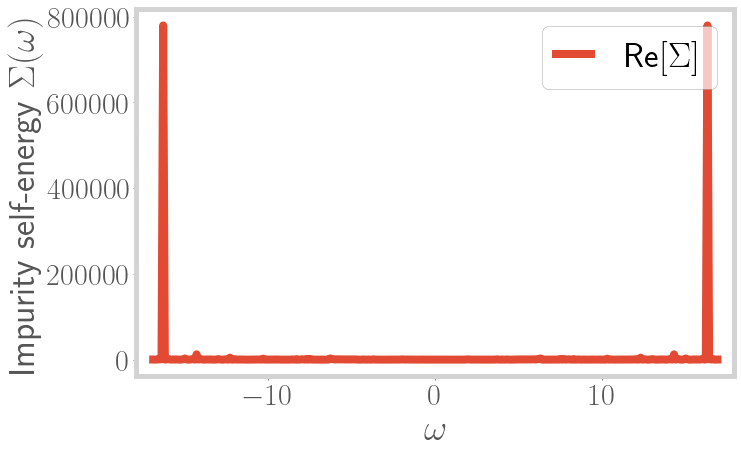

100%|███████████████████████████████████████| 1001/1001 [00:30<00:00, 32.68it/s]


[-20191.60955583+5.63628794e+03j   3817.07784927+5.17251806e+03j
  -6078.21837951+4.73034009e+03j  -3891.40002478+4.28242902e+03j
  -3411.63297535+3.80672888e+03j  -2396.98352559+3.27059219e+03j
  -2599.80652243+2.63891454e+03j   2590.76218833+1.88506597e+03j
   2015.54388999+1.05046717e+03j   1524.47791193+3.17081971e+02j
      0.        -1.12035229e+08j  -1524.47791193+3.17081971e+02j
  -2015.54388999+1.05046717e+03j  -2590.76218833+1.88506597e+03j
   2599.80652243+2.63891454e+03j   2396.98352559+3.27059219e+03j
   3411.63297535+3.80672888e+03j   3891.40002478+4.28242902e+03j
   6078.21837951+4.73034009e+03j  -3817.07784927+5.17251806e+03j
  20191.60955582+5.63628794e+03j]


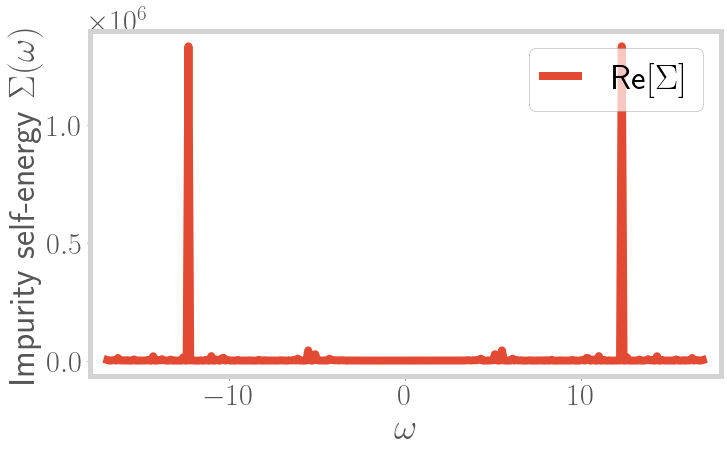

In [137]:
_ = plot_selfenergy({"D0": 100, "V0": 1.3, "J0_arr": [2, 4.2], "factor_arr": [0.16, 0.21],
                                    "broad_guess_arr": [1.3, 0.8570286, 0.4944776, 0.0569437], "num_sites": 2, "num_points": 1001,
                                    "eta_delta": 1e4, "use_guess": False, "no_Ub": False, "omega_end": 17, "ops": (0,0), "plot": True})

## **ZERO-MODE SPECTRUM**
<hr style="border:2px solid skyblue">

In [ ]:
def twosite_spectrum():
    J = 1
    Ub_range1 = np.arange(-0.1, -3*J/2, -0.01)
    Ub_range2 = np.arange(-3*J/2, -2, -0.01)
    Ub_range = np.arange(-0.1, -2, -0.01)

    E_ss = -3*J/4 - Ub_range1/2
    E_st = J/4 - Ub_range1/2
    E_charge = Ub_range * 0
    E_lm_lm = -Ub_range2/2

    plt.rcParams["figure.figsize"] = (11,6)
    plt.plot(-(2/3)*Ub_range1/J, E_ss)
    plt.plot(-(2/3)*Ub_range/J, E_charge)

    plt.annotate(r"$\ket{S=0}$", (0.6,-0.4))
    plt.annotate(r"$\ket{\pm \frac{1}{2}}\otimes\ket{0,2}$", (1.02, -0.1))
    plt.annotate(r"$-\frac{3\mathcal{\tilde J}}{4} - \frac{\mathcal{\tilde U}_b}{2}$", (0.13,-0.25), size=40)
    plt.arrow(0.45, -0.38, 0, 0.32, width=0.008, color="gray")
    plt.arrow(0.45, -0.05, 0, -0.31, width=0.008, color="gray")

    plt.xlabel(r"$-2 \mathcal{\tilde U}_b/3 \mathcal{\tilde J}$")
    plt.ylabel(r"energy eigenvalues")

    plt.savefig(fig_save_path + "twosite_spectrum.pdf", bbox_inches='tight')
    
twosite_spectrum()